### Auditing Allocative Bias

[Source code is here.](https://github.com/jackgreenburg/jackgreenburg.github.io/blob/main/posts/auditing-allocative-bias/????.py)

In this blog post I audited allocative bias

In [1]:
# from linreg import LinearRegression # your source code

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
def draw_line(w, x_min, x_max, *, color="black", ax=None, alpha=1, **kwargs):
  x = np.linspace(x_min, x_max, 101)
  if len(w) == 3:
    y = -(w[0]*x + w[2])/w[1]
  elif len(w) == 2:
    y = w[0]*x + w[1]
  if ax is None:
    plt.plot(x, y, color = color, alpha=alpha, **kwargs)
  else:
    ax.plot(x, y, color = color, alpha=alpha, **kwargs)

In [3]:
def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

In [4]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter

# I chose to stay using Alabama, since they didn't seem to have DC. Roll Tide
STATE = "AL"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

I picked these values:
- SCHL - level of schooling
- MAR - marital status
- AGEP - age
- MIL - military experience 
- DIS - disability
- NATIVITY - foreign born or not

Also note, for RAC1P:
1. White alone
2. Black or African American alone
3. American Indian alone
4. Alaska Native alone
5. American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races
6. Asian alone
7. Native Hawaiian and Other Pacific Islander alone
8. Some Other Race alone
9. Two or More Races

But 4, 5, and 6 did not have enough to compute Data for, so I folded them into the Some Other Race category. The new indices are:
1. White alone
2. Black or African American alone
3. American Indian alone
4. Asian alone
5. Some Other Race alone
6. Two or More Races

In [5]:
# feature_categories = ["SCHL", "MAR", "AGEP", "DIS", "NATIVITY"]
feature_categories = ["SCHL", "MAR", "AGEP", "DIS", "SEX"]

EmploymentProblem = BasicProblem(
    features=feature_categories,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

# fold some races into other category
group[(group==4) | (group==5) | (group==7)] = 8
group[group==6] = 4
group[group==8] = 5
group[group==9] = 6

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

df = pd.DataFrame(X_train, columns = feature_categories)
df["group"] = group_train
df["label"] = y_train

##### Some questions and some answers:

1. There are 38221 individuals in the dataset.
2. Of those individuals, 15638 are employed
3, 4. Number and ratio employed by group:
     Race                     Employed      Ratio Employed
  1. White:                     12020              42.26% 
  2. Black:                      2976              36.88% 
  3. American Indian:              68              43.59% 
  4. Asian:                       226               50.0% 
  5. Other Race:                  157              35.76% 
  6. Two or More Races:           191              28.81% 
5. A plot showing employment by race and disability status:


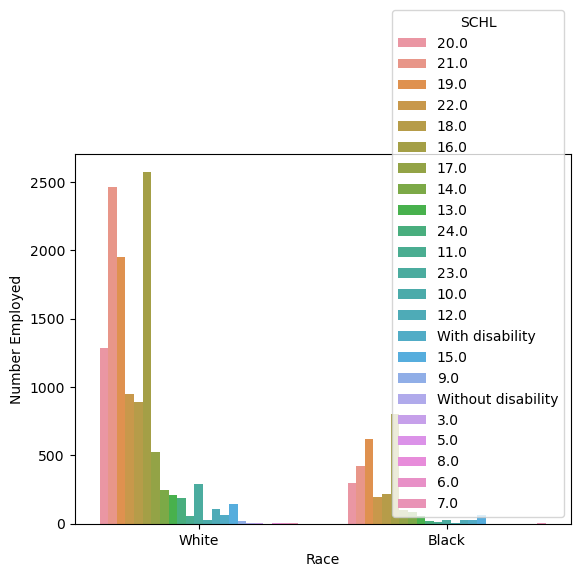

In [76]:
races = [
    "White",
    "Black",
    "American Indian",
    "Asian",
    "Other Race",
    "Two or More Races"
]

print(f"1. There are {df.shape[0]} individuals in the dataset.")
print(f"2. Of those individuals, {df.label.sum()} are employed")
print(f"3, 4. Number and ratio employed by group:")

employee_races = df[df["label"] == True]["group"]
employed_per_group = employee_races.value_counts(sort=False)
ratio_employed_per_group = employed_per_group/df["group"].value_counts(sort=False)

print("     Race".ljust(28) + "Employed".rjust(10) + "Ratio Employed".rjust(20))
for index, race in enumerate(races):
    line = f"  {index+1}. {race}:".ljust(28)
    line += f"{employed_per_group[index+1]} ".rjust(10)
    line += f"{round(ratio_employed_per_group[index+1] * 100, 2)}% ".rjust(20)
    print(line)

group_dict = {i+1: status for i, status in enumerate(races)}
mar_dict = {i+1: status for i, status in enumerate(["With disability", "Without disability"])}

intersectional_df = df[df["group"].isin([1, 2])].query("label==True")
intersectional_df = intersectional_df.replace({"DIS": mar_dict, "group": group_dict})
ax = sns.countplot(data=intersectional_df, x="group", hue="DIS")
ax.set(xlabel='Race', ylabel='Number Employed')
print(f"5. A plot showing employment by race and disability status:")



### Creating a Predictor

In [7]:

# parameters = {"gradientboostingclassifier__max_depth": (5, 10),
#               "gradientboostingclassifier__max_features": (10, 20, 50)}
# pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier())
# clf = GridSearchCV(pipeline, 
#                    parameters, 
#                    scoring="accuracy")
# clf.fit(X_train, y_train)

pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(max_depth=5, max_features=10))
clf = pipeline.fit(X_train, y_train)


y_pred = clf.predict(X_test)

print(f"Overall accuracy: {round((y_pred == y_test).mean()*100, 2)}")
print(f"Accuracy for white people: {round((y_pred == y_test)[group_test == 1].mean()*100, 2)}")
print(f"Accuracy for black people: {round((y_pred == y_test)[group_test == 2].mean()*100, 2)}")
print(f"Accuracy for white people: {round((y_pred == y_test)[group_test == 1].mean()*100, 2)}")



Overall accuracy: 80.93
Accuracy for white people: 80.89
Accuracy for black people: 81.12
Accuracy for white people: 80.89


In [9]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, max_features=10))])>

### Auditing the Model

##### Overall Measures

- What is the overall accuracy of your model?
- What is the positive predictive value (PPV) of your model?
- What are the overall false negative and false positive rates (FNR and FPR) for your model?

In [10]:
def compute_measures(*, y_test, y_pred):
    (TN, FP), (FN, TP) = confusion_matrix(y_test, y_pred)
    data = {
        "Accuracy": (y_pred == y_test).mean(),
        "PPV": TP / (TP+FP),
        "FPR": FP / (FP+TN),
        "FNR": FN / (TP+FN)       
    }
    # for key, value in data.items(): print(f"{key}: {round(value * 100, 2)}%")
    return data

print("All data:")
compute_measures(y_test=y_test, y_pred=y_pred)

audit_dict = {}
for index, race in group_dict.items():
    # race = group_dict[index]
    print(f"\n{race} subgroup:")
    audit_dict[race] = compute_measures(y_test=y_test[group_test==index], y_pred=y_pred[group_test==index])

pd.DataFrame(audit_dict).T

All data:

White subgroup:

Black subgroup:

American Indian subgroup:

Asian subgroup:

Other Race subgroup:

Two or More Races subgroup:


,Accuracy,PPV,FPR,FNR
White,0.808861,0.773256,0.172949,0.215339
Black,0.811247,0.718905,0.172915,0.216802
American Indian,0.807692,0.777778,0.125000,0.300000
Asian,0.730769,0.701754,0.320755,0.215686
Other Race,0.868687,0.909091,0.050847,0.250000
Two or More Races,0.819767,0.642857,0.160000,0.234043


In [12]:
for feat, importance in zip(feature_categories, clf[1].feature_importances_):
    print(f"{feat}:, {importance}")

SCHL:, 0.363814256958526
MAR:, 0.026998801049798092
AGEP:, 0.46469939735320914
DIS:, 0.11379876498677088
SEX:, 0.030688779651696044


##### Bias Measures
- Is your model approximately calibrated?

  My model should be calibrated. The score threshold for a positive prediction should be the same across all samples in the dataset.

- Does your model satisfy approximate error rate balance?

  My model does not fully satisfy error rate balance. It does satisfy for the two largest groups (white and black), which have nearly the same FPR~17% and FNR~22%. It does not satisfy many of the other classes, with the FPR for Asians being close to twice as high, and the FPR for the Other Race category being a third 

- Does your model satisfy statistical parity?